In [33]:
# !pip install pycaret


In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from pycaret.time_series import *

os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [54]:
data = pd.read_csv("data/petr_brent.csv")
# data = pd.read_csv('/kaggle/input/petr-brent-ipeadata/petr_brent.csv')

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         7600 non-null   object 
 1   CODE         7600 non-null   object 
 2   RAW DATE     7600 non-null   object 
 3   DAY          7600 non-null   int64  
 4   MONTH        7600 non-null   int64  
 5   YEAR         7600 non-null   int64  
 6   VALUE (US$)  7459 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 415.8+ KB


In [55]:
data.index = pd.to_datetime(data["DATE"])
start = data.index[0].date()
end = data.index[len(data) - 1].date()
new_dates = pd.date_range(start=start, end=end, freq="D")
data = data.reindex(new_dates)
data = data.rename_axis("DATE")
data["VALUE (US$)"] = data["VALUE (US$)"].interpolate().bfill()
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8169 entries, 2002-01-01 to 2024-05-13
Freq: D
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         7600 non-null   object 
 1   CODE         7600 non-null   object 
 2   RAW DATE     7600 non-null   object 
 3   DAY          7600 non-null   float64
 4   MONTH        7600 non-null   float64
 5   YEAR         7600 non-null   float64
 6   VALUE (US$)  8169 non-null   float64
dtypes: float64(4), object(3)
memory usage: 510.6+ KB


In [56]:
data.drop(["DATE", "CODE", "RAW DATE"], axis=1, inplace=True)
data.head()


DAY  MONTH    YEAR  VALUE (US$)
DATE                                       
2002-01-01  1.0    1.0  2002.0        20.13
2002-01-02  2.0    1.0  2002.0        20.13
2002-01-03  3.0    1.0  2002.0        20.47
2002-01-04  4.0    1.0  2002.0        21.20
2002-01-05  5.0    1.0  2002.0        21.16

In [57]:
# df.plot(style='.', figsize=(15,5), color=color_pal[0], title = "PJME Energy Use in Mega walt (MW)");
data["VALUE (US$)"].plot(
    style=".", figsize=(15, 5), color=color_pal[0], title="Preço Petróleo tipo Brent"
)


<Axes: title={'center': 'Preço Petróleo tipo Brent'}, xlabel='DATE'>

In [58]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.day_of_year
    return df


df = create_features(data)


In [59]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8169 entries, 2002-01-01 to 2024-05-13
Freq: D
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DAY          7600 non-null   float64
 1   MONTH        7600 non-null   float64
 2   YEAR         7600 non-null   float64
 3   VALUE (US$)  8169 non-null   float64
 4   hour         8169 non-null   int32  
 5   dayofweek    8169 non-null   int32  
 6   quarter      8169 non-null   int32  
 7   month        8169 non-null   int32  
 8   year         8169 non-null   int32  
 9   dayofyear    8169 non-null   int32  
dtypes: float64(4), int32(6)
memory usage: 510.6 KB


In [60]:
df.drop(["DAY", "MONTH", "YEAR"], axis=1, inplace=True)
df.head()


VALUE (US$)  hour  dayofweek  quarter  month  year  dayofyear
DATE                                                                     
2002-01-01        20.13     0          1        1      1  2002          1
2002-01-02        20.13     0          2        1      1  2002          2
2002-01-03        20.47     0          3        1      1  2002          3
2002-01-04        21.20     0          4        1      1  2002          4
2002-01-05        21.16     0          5        1      1  2002          5

In [61]:
df = df.loc["2018-01-01":]
fh = int(len(df) * 0.10)


In [62]:
experiment = TSForecastingExperiment()
# experiment.setup(data=target, fh=180, fold=5, use_gpu=True, scale_target='maxabs')
experiment.setup(
    data=df,
    target="VALUE (US$)",
    fh=fh,
    fold=4,
    use_gpu=True,
    verbose=True,
    # scale_target="maxabs"
)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there a

In [63]:
experiment.plot_model(
    data_kwargs={"ts": "original"},
)


In [64]:
experiment.plot_model(data_kwargs={"plot_data_type": ["transformed"]})


In [65]:
experiment.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})


In [66]:
experiment.plot_model(
    plot="diff",
    data_kwargs={
        "lags_list": [[1], [1, 16]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    fig_kwargs={"height": 800, "width": 1500},
)


In [67]:
experiment.plot_model(plot="train_test_split", fig_kwargs={"height": 400, "width": 900})


In [68]:
experiment.plot_model(plot="decomp_stl", fig_kwargs={"height": 400, "width": 900})


In [69]:
experiment.check_stats()


Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting         Value  
0                                   2325.0  
1                                      0.0  
2                                72.605204  
3                                  73.1525  
4                                19.767979  
5                               390.773012  
6                                 0.714218  
7                                  -0.0682  
8                                   1950.0  
9   {'alpha': 0.05, 'K': 24}  52264.990111  
10  {'alpha': 0.05, 'K': 48}  96816.732107  
11  {'alpha': 0.05, 'K': 24}           0.0  
12  {'alpha': 0.05, 'K': 48}           0.0  
13  {'alpha': 0.05, 'K': 24}           0.0  
14  {'alpha': 0.05, 'K': 48}           0.0  
15           {'alpha': 0.05}         False  
16           {'alpha': 0.05}      0.378874  
17           {'alpha': 0.05}     -1.803201  
18           {'alpha': 0.05}     -3.433188  
19           {'alpha': 0.05}     -2.862794  
20           {'alpha': 0.05}     -2.567437  
21           {'alpha': 0.05}         False  
22           {'alpha': 0.05}          0.01  
23           {'alpha': 0.05}       0.75531  
24           {'alpha': 0.05}         0.119  
25           {'alpha': 0.05}         0.146  
26           {'alpha': 0.05}         0.176  
27           {'alpha': 0.05}         0.216  
28           {'alpha': 0.05}         False  
29           {'alpha': 0.05}           0.0

In [70]:
experiment.models()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there a

Name  \
ID                                                                   
arima                                                        ARIMA   
auto_arima                                              Auto ARIMA   
croston                                                    Croston   
lr_cds_dt               Linear w/ Cond. Deseasonalize & Detrending   
en_cds_dt          Elastic Net w/ Cond. Deseasonalize & Detrending   
ridge_cds_dt             Ridge w/ Cond. Deseasonalize & Detrending   
lasso_cds_dt             Lasso w/ Cond. Deseasonalize & Detrending   
llar_cds_dt      Lasso Least Angular Regressor w/ Cond. Deseaso...   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending   
omp_cds_dt       Orthogonal Matching Pursuit w/ Cond. Deseasona...   
knn_cds_dt         K Neighbors w/ Cond. Deseasonalize & Detrending   
dt_cds_dt        Decision Tree w/ Cond. Deseasonalize & Detrending   
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending   
et_cds_dt          Extra Trees w/ Cond. Deseasonalize & Detrending   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...   
ada_cds_dt            AdaBoost w/ Cond. Deseasonalize & Detrending   
xgboost_cds_dt   Extreme Gradient Boosting w/ Cond. Deseasonali...   
lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...   
catboost_cds_dt  CatBoost Regressor w/ Cond. Deseasonalize & De...   

                                                         Reference  Turbo  
ID                                                                         
arima                               sktime.forecasting.arima.ARIMA   True  
auto_arima                      sktime.forecasting.arima.AutoARIMA   True  
croston                         sktime.forecasting.croston.Croston   True  
lr_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
en_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
ridge_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
lasso_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
llar_cds_dt      pycaret.containers.models.time_series.BaseCdsD...   True  
br_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
huber_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
omp_cds_dt       pycaret.containers.models.time_series.BaseCdsD...   True  
knn_cds_dt       pycaret.containers.models.time_series.BaseCdsD...   True  
dt_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
rf_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
et_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
gbr_cds_dt       pycaret.containers.models.time_series.BaseCdsD...   True  
ada_cds_dt       pycaret.containers.models.time_series.BaseCdsD...   True  
xgboost_cds_dt   pycaret.containers.models.time_series.BaseCdsD...   True  
lightgbm_cds_dt  pycaret.containers.models.time_series.BaseCdsD...   True  
catboost_cds_dt  pycaret.containers.models.time_series.BaseCdsD...   True

In [71]:
# include = ["ridge_cds_dt", "arima", "huber_cds_dt", "lightgbm_cds_dt", "knn_cds_dt",
#            "gbr_cds_dt","br_cds_dt", "dt_cds_dt", "rf_cds_dt", "ada_cds_dt",
#            "prophet", "omp_cds_dt", "xgboost_cds_dt"]
include = [
    "xgboost_cds_dt",
    "lightgbm_cds_dt",
    "knn_cds_dt",
    "gbr_cds_dt",
    "rf_cds_dt",
    "catboost_cds_dt",
    "br_cds_dt",
]
exclude = ["auto_arima", "bats", "tbats", "lar_cds_dt", "par_cds_dt"]


In [72]:
metric = "mape"
best = experiment.compare_models(n_select=5, include=include, sort=metric, turbo=True)


In [73]:
compare_metrics = experiment.pull()


In [74]:
compare_metrics


Model    MASE  \
xgboost_cds_dt   Extreme Gradient Boosting w/ Cond. Deseasonali...  2.0483   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...  3.0671   
lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...  3.0965   
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending    3.18   
catboost_cds_dt  CatBoost Regressor w/ Cond. Deseasonalize & De...  4.0392   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...  3.9992   
knn_cds_dt         K Neighbors w/ Cond. Deseasonalize & Detrending  6.2305   

                  RMSSE      MAE     RMSE    MAPE   SMAPE       R2  TT (Sec)  
xgboost_cds_dt   1.8622   9.7881  12.2525  0.1046  0.1124   -0.623   14.5800  
gbr_cds_dt       2.6318  15.0488  17.6824  0.1663  0.1607  -2.1071   12.3550  
lightgbm_cds_dt  2.6387  15.1857  17.7242  0.1685  0.1636  -2.2135   13.4825  
rf_cds_dt        2.6963  15.6339  18.1442  0.1728  0.1657  -2.3548   19.1875  
catboost_cds_dt   3.371  19.5207  22.3484  0.2108  0.2213  -3.4129   26.6325  
br_cds_dt        3.4148  19.3205  22.6929  0.2188   0.236  -5.8665   10.7000  
knn_cds_dt       5.4107  29.8916  35.6566  0.3256  0.4365 -14.3381   14.0375

In [75]:
compare_metrics.to_csv("compare_metrics_multi.csv")


In [76]:
experiment.plot_model(best, plot="forecast")


## Somente o melhor modelo para previsão

In [78]:
# escolhendo somente o melhor modelo
xgb_model = experiment.create_model("xgboost_cds_dt")


In [80]:
experiment.plot_model(xgb_model, plot="forecast")


In [82]:
xgb_tunned = experiment.tune_model(xgb_model, round=5, n_iter=20, optimize="MAPE")


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.4min finished


In [83]:
final_xgb_model = experiment.finalize_model(xgb_tunned)


In [85]:
experiment.exogenous_variables


['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']

In [86]:
def safe_predict(exp, model):
    """Prediction wrapper for demo purposes."""
    try:
        exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(
            f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}"
        )


safe_predict(experiment, final_xgb_model)


Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
6 exogenous variables (X) needed in order to make future predictions:
['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']


In [87]:
_ = experiment.save_model(final_xgb_model, "final_xgb_model")


Transformation Pipeline and Model Successfully Saved


In [89]:
final_exog_model = final_xgb_model


In [92]:
exog_vars = experiment.exogenous_variables
data = df[exog_vars]
data.head()


hour  dayofweek  quarter  month  year  dayofyear
DATE                                                        
2018-01-01     0          0        1      1  2018          1
2018-01-02     0          1        1      1  2018          2
2018-01-03     0          2        1      1  2018          3
2018-01-04     0          3        1      1  2018          4
2018-01-05     0          4        1      1  2018          5

In [96]:
def safe_predict(exp, model):
    """Prediction wrapper for demo purposes."""
    try:
        future_preds = exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(
            f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}"
        )

        exog_exps = []
        exog_models = []
        for exog_var in exog_vars:
            exog_exp = TSForecastingExperiment()
            exog_exp.setup(
                data=data[exog_var],
                fh=180,
                numeric_imputation_target="ffill",
                numeric_imputation_exogenous="ffill",
                session_id=42,
            )

            # Users can customize how to model future exogenous variables i.e. add
            # more steps and models to potentially get better models at the expense
            # of higher modeling time.
            best = exog_exp.compare_models(
                sort="mape", include=["xgboost_cds_dt", "arima", "lightgbm_cds_dt"]
            )
            final_exog_model = exog_exp.finalize_model(best)

            exog_exps.append(exog_exp)
            exog_models.append(final_exog_model)

        # Step 2: Get future predictions for exog variables ----
        future_exog = [
            exog_exp.predict_model(exog_model)
            for exog_exp, exog_model in zip(exog_exps, exog_models)
        ]
        future_exog = pd.concat(future_exog, axis=1)
        future_exog.columns = exog_vars

        future_preds = exp.predict_model(model, X=future_exog)

    return future_preds


In [97]:
future_preds = safe_predict(experiment, final_xgb_model)


Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
6 exogenous variables (X) needed in order to make future predictions:
['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']


<Axes: >

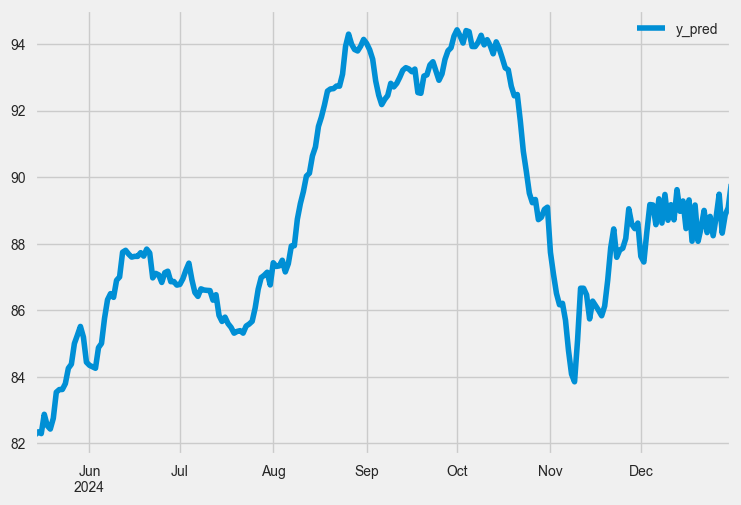

In [100]:
future_preds.plot()


## Blend dos 5 melhores modelos

In [ ]:
best_tuned_models = [experiment.tune_model(model) for model in best]


In [26]:
# Get model weights to use
top_model_metrics = compare_metrics.iloc[0:5][metric.upper()]
display(top_model_metrics)

top_model_weights = 1 - top_model_metrics / top_model_metrics.sum()
display(top_model_weights)


xgboost_cds_dt     0.1046
rf_cds_dt          0.1528
gbr_cds_dt         0.1665
ada_cds_dt         0.1672
lightgbm_cds_dt    0.1685
Name: MAPE, dtype: object

xgboost_cds_dt     0.862296
rf_cds_dt          0.798841
gbr_cds_dt         0.780806
ada_cds_dt         0.779884
lightgbm_cds_dt    0.778173
Name: MAPE, dtype: object

In [27]:
blender = experiment.blend_models(
    best_tuned_models,
    method="gmean",
    optimize="MAPE",
    weights=top_model_weights.values.tolist(),
)


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging

In [28]:
y_predict = experiment.predict_model(blender)
y_predict


y_pred
2023-09-25  94.0980
2023-09-26  94.3741
2023-09-27  94.2744
2023-09-28  93.9104
2023-09-29  93.7780
...             ...
2024-05-09  94.2444
2024-05-10  94.1091
2024-05-11  94.0091
2024-05-12  93.8397
2024-05-13  94.1188

[232 rows x 1 columns]

In [29]:
experiment.plot_model(estimator=blender)


In [30]:
final_model = experiment.finalize_model(blender)
print(
    experiment.predict_model(
        final_model,
        fh=90,
    )
)
experiment.plot_model(final_model)


ValueError: Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.

In [ ]:
_ = experiment_uni.save_model(final_model, "petr_blender_model_multi")


In [ ]:
# Load saved model
loaded_exp = TSForecastingExperiment()
m = loaded_exp.load_model("petr_blender_model_multi")
# m = loaded_exp.load_experiment("petr_blender_model", preprocess_data = False)
# Predictions should be same as before the model was saved and loaded
# loaded_exp.setup(scale_target='maxabs'
loaded_data = loaded_exp.predict_model(m)


In [ ]:
loaded_data
